# DDPM Tutorial

We use PyTorch Lightning to train and sample from a diffusion model. Where possible, we reference equation numbers from the [DDPM Paper](https://arxiv.org/pdf/2006.11239) (Ho et al., 2020).

In [1]:
import os
import sys
sys.path.append('../')
import hydra
import torch
import math
import random
import lightning as L
from lightning import Trainer
from omegaconf import DictConfig
from torch import utils
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor

from diffusion import DDPM
import matplotlib.pyplot as plt

Use use `hydra` to configure experiments. See the [docs](https://hydra.cc/docs/intro/) for more details. Here, we load the `config.yaml` file.

In [2]:
from hydra import compose, initialize
with initialize(version_base=None, config_path="../"):
    cfg = compose(config_name="config")
print(cfg)
seed = cfg.seed
L.seed_everything(seed)

Seed set to 784953


{'seed': 784953, 'training': {'batch_size': 64, 'lr': 0.0001, 'gpu_num': 7}, 'forward_process': {'beta_min': 1e-05, 'beta_max': 0.1, 'T': 1000}, 'logging': {'log_dir': 'logging'}}


784953

In [3]:
dataset = MNIST(os.getcwd(), download=True, transform=ToTensor())
images = dataset.data / 255.0 * 2 - 1
train_loader = utils.data.DataLoader(images, cfg.training.batch_size)

beta_min = cfg.forward_process.beta_min
beta_max = cfg.forward_process.beta_max
T = cfg.forward_process.T
min_exp = math.log10(beta_min)
max_exp = math.log10(beta_max)
betas = torch.logspace(min_exp, max_exp, T)
device_name = "cuda:{}".format(cfg.training.gpu_num)
betas = betas.to(device_name)

The code above accesses key attributes from the config file, and downloads the MNIST dataset from `torchvision`. The `betas` quantity defines a variance schedule (see Eq. 2 of DDPM), and is encoded as a length `T` tensor. The integer `T` is thus the number of steps in the forward and reverse Markov processes.

In [4]:
diffusion_model = DDPM(
    betas,
    device_name,
)

The diffusion model module (a subclass of `LightningModule` from PyTorch Lightning) consists of 4 key quantities:
- a conditional mean network (a UNet architecture)
- a conditional covariance network 
- a forward process 
- a reverse process

We'll walk through these four ingredients in detail -- some contribute to the training objective directly, while others are there for structural clarity.

###### The forward process

The forward process (defined in `processes.ForwardProcess`) is a module that defines the structure of a noising process. Supplied with a batch of images, it adds noise according to the noise schedule defined by the `betas`. 

In [5]:
x_0 = next(iter(train_loader)).to(device_name)
print(x_0.shape)
_, x_T = diffusion_model.forward_process.sample(x_0, T-1)

torch.Size([64, 28, 28])


In [6]:
x_T.shape

torch.Size([64, 28, 28])

Text(0.5, 1.0, 'Noisy MNIST Digit')

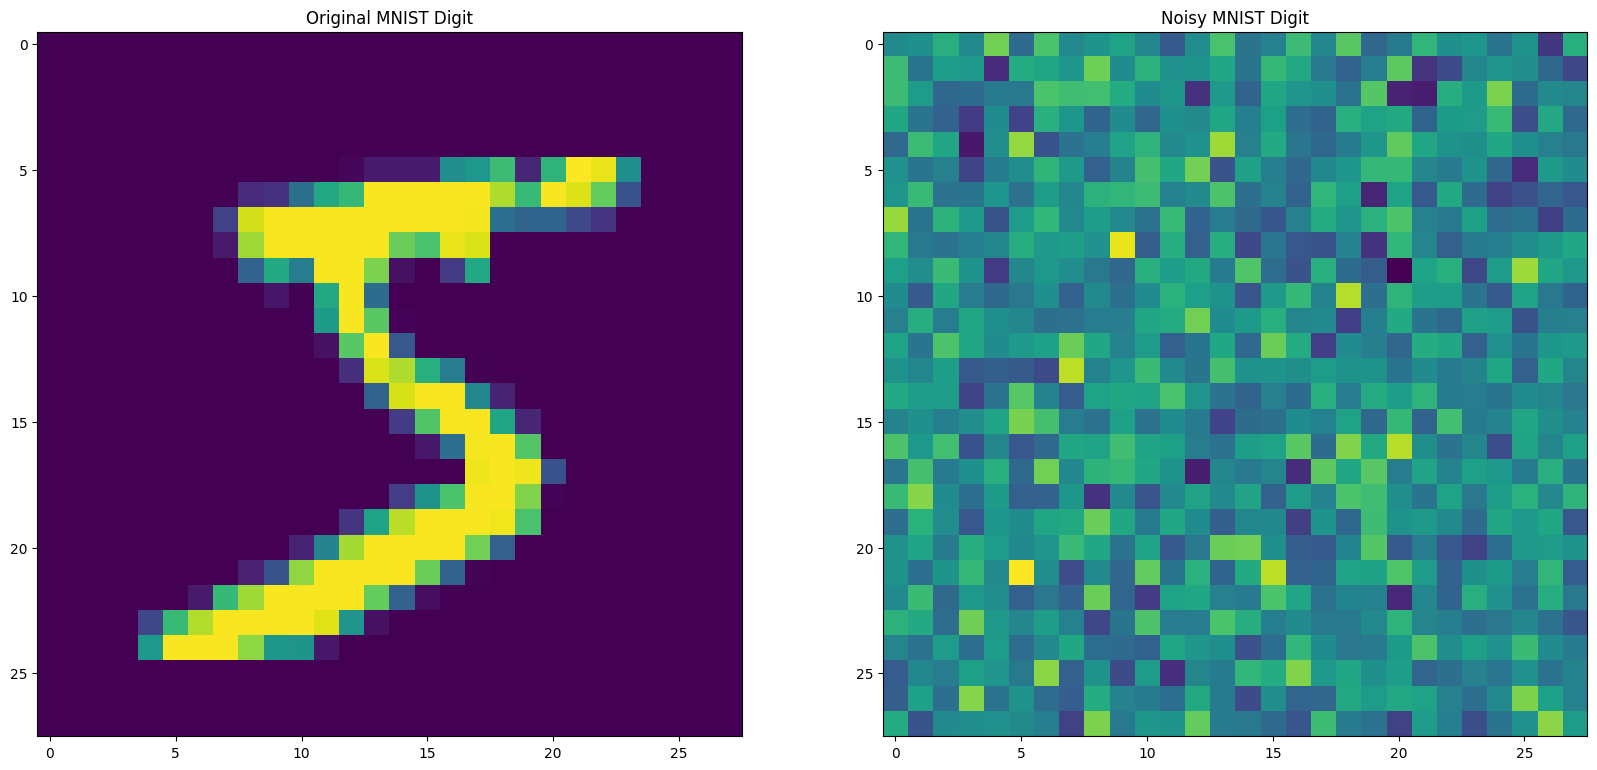

In [7]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,10))
ax[0].imshow(x_0[0].cpu())
ax[1].imshow(x_T[0].cpu())
ax[0].set_title('Original MNIST Digit')
ax[1].set_title('Noisy MNIST Digit')

###### The conditional mean network

The neural network $\mu_\theta$ takes two inputs: a batch of observations $x_t$, and a stage $t$. Given these, the prediction 

$$
\hat{x}_{t-1} = \mu_\theta(x_t, t)
$$

is the predicted mean of $x_{t-1}$ conditional on $x_t$ (and the stage $t$). The conditional mean network, once fitted, essentially defines the backward process. Beginning at stage $T$ with an observation $x_T$ drawn from a standard multivariate Gaussian, we can iteratively apply the conditional mean network going backward to sample $x_0$. This heuristic scheme is not probabilistic, and noise is added in the true implementation according to a noise schedule to make the paradigm probabilistic.

###### The conditional covariance network

We really want to know the true conditional distribution of $x_{t-1}$ conditional on $x_{t}$. It is parameterized as a Gaussian with mean $\mu_\theta(x_t, t)$ and covariance $\Sigma_\phi(x_t, t)$. Following DDPM (see Section 3.2), the conditional covariance is set deterministically using the noising schedule defined by the `betas` in our implementation -- therefore, there are no learnable parameters $\phi$ to be fit.

###### The reverse process

The reverse process (defined in `processes.BackwardProcess`) is a module that defines the structure of the reverse Markov process. It is defined by the `betas` (which yield the conditional covariances); a `base_dist` (taken to be standard multivariate Gaussian due to the nature of the noising process); and the `mean_network` and `cov_network` outlined above. 

The reverse process starts with $x_T \sim \mathcal{N}(0, I)$ and iteratively constructs a sequence of random variables as follows:

$$
x_{t-1} \mid x_t \sim \mathcal{N}(\mu_\theta(x_t, t), \Sigma_\phi(x_t,t))$
$$

At the end of sampling, $x_0$ is drawn and these realizations are taken as simulated draws from the data distribution.

### Training

Eqns (8)-(12) of DDPM derive the form of the training objective. Key to the derivation are several key observations:

1. Given $x_0$, the r.v. $x_t$ can reparameterized as a deterministic linear combination of $x_0$ and a draw $\epsilon \sim \mathcal{N}(0, I)$ via $$x_t = \sqrt{\bar{\alpha}_t} x_0 + \sqrt{1-\bar{\alpha}_t} \epsilon, $$ where the $\bar{\alpha}_t$'s are functions of the $\beta_t$'s (our `betas` above). Consequently, $x_0$ can be written as a linear combination of $x_t$ and $\epsilon$ as well.

2. The conditional distribution of $x_{t-1}$ given $x_t, x_0$ is Gaussian with known mean and covariance (Eqns (6) and (7)). Using the observation above, we can replace $x_0$ with additional $x_t$ and $\epsilon$ terms.

3. Derivations based on #1, #2 yield that the conditional mean of $x_{t-1}$ given $x_t, \epsilon$ is 
$$
\frac{1}{\sqrt{\alpha}_t} \left( x_t - \frac{\beta_t}{\sqrt{1-\bar{\alpha}_t}} \cdot \epsilon\right).
$$
Accordingly, we can try to predict the noise $\epsilon$ and compute the expression above, instead of trying to predict the conditional mean of $x_{t-1}$ in total generality.

These observations (and a few others, please read the DDPM paper for details) amount to a training objective that simplifies to the following algorithm:

- Sample a $t \sim \mathrm{Unif}(1, \dots, T)$
- Draw $\epsilon \sim \mathcal{N}(0, I)$.
- Compute $x_t = \sqrt{\bar{\alpha}_t} x_0 + \sqrt{1-\bar{\alpha}_t} \epsilon$. 
- Given $x_t$, try to predict $\epsilon$ using a neural network that accepts $x_t, t$ as inputs. Call the prediction $\hat{\epsilon}$.
- Compute the loss $||\hat{\epsilon}-\epsilon||_2^2$
- Repeat

Thus DDPM truly tries to perform "denoising"; given a corrupted observation $x_t$ it tries to learn the noise that corrupted it. We have omitted plenty of details here. In the implementation, we follow the convention of ignoring the leading constants in Eq. 12 to yield the algorithm above, which mirrors Algorithm 1 of DDPM.

In implementation, only slight modifications are needed to implement the algorithm above. Namely, the network $\mu_\theta$ described above still *parameterizes* $\hat{x}_t$, but indirectly. The network outputs are

$$
\hat{\epsilon} = \mu_\theta(x_t, t) \\
$$
after which we can compute the conditional mean of $x_{t-1}$ as

$$
\hat{x}_{t-1} = \frac{1}{\sqrt{\alpha}_t} \left( x_t - \frac{\beta_t}{\sqrt{1-\bar{\alpha}_t}} \cdot \hat{\epsilon}\right)
$$

In [8]:
# We don't actually run it here
trainer = Trainer(
    devices=[cfg.training.gpu_num],
    accelerator="gpu",
    default_root_dir="./{}".format(cfg.logging.log_dir),
    max_epochs=100,
)
# trainer.fit(diffusion_model, train_dataloaders=train_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


### Generate

After having trained the diffusion model, we can simulate new observations by sampling from the reverse process above. We include a checkpoint in the repository that can be loaded to explore the prefitted model.

In [9]:
directory = "../weights"
file_name = os.listdir(directory)[0]
diffusion_model.load_state_dict(torch.load(os.path.join(directory, file_name), weights_only=True)["state_dict"])

<All keys matched successfully>

The reverse process module (`processes.BackwardProcess`) includes a `sample_K` function that samples $K$ observations from the reverse process, starting with the base distribution (a standard multivariate Gaussian). Sampling is pretty slow because it requires a for-loop through all $T$ stages of the diffusion model. 

In [10]:
sampled_images_from_noise = diffusion_model.backward_process.sample_K(t=0, K=100)

The $t$ argument tells the sampling procedure where to terminate; $t=0$ means to run the full reverse process up to sampling $x_0$. The output of this function is a length $T$ list, each entry of which is a Tensor of shape `(K, ...)` for each of the `K` samples

We can plot the evolution of the of the samples as $T$ decreases from $T$ to $0$. 

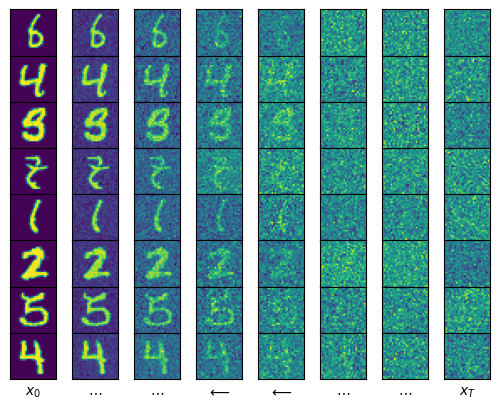

In [11]:
to_examine_t = [-1, -250, -500, -650, -750, -850, -950, -1000]
entries_K = range(8)
fig, ax = plt.subplots(nrows=8, ncols=8)
for i in range(0, 8):
    for j in range(0, 8):
        ax[i,j].imshow(
            sampled_images_from_noise[to_examine_t[j]][entries_K[i]]
            .reshape((28, 28))
            .detach()
            .cpu()
            .numpy()
        )
        ax[i,j].set_yticklabels([])
        ax[i,j].set_xticklabels([])
        
        ax[i,j].set_xticks([])
        ax[i,j].set_yticks([])

ax[-1][-1].set_xlabel('$x_T$')
ax[-1][-2].set_xlabel('$\cdots$')
ax[-1][-3].set_xlabel('$\cdots$')
ax[-1][-4].set_xlabel('$\longleftarrow$')
ax[-1][-5].set_xlabel('$\longleftarrow$')
ax[-1][-6].set_xlabel('$\cdots$')
ax[-1][-7].set_xlabel('$\cdots$')
ax[-1][0].set_xlabel('$x_0$')
fig.subplots_adjust(wspace=0, hspace=0)

#plt.tight_layout()
#plt.show()
plt.savefig('cover_fig.png', bbox_inches='tight')